# Maestría en Inteligencia Artificial Aplicada 

## Curso: Proyecto Integrador (Grupo 10) 

## Avance 6. Conclusiones Clave.
<br />

### Profesor titular  
#### Dra. Grettel Barceló Alonso 
#### Dr. Luis Eduardo Falcón Morales  
#### Dra. María de la Paz Rico Fernández
<br />

<table>
<tr>
    <th colspan="2">Equipo 19: Los Californios I</th>
</tr>
<tr>
    <td>Ernesto Zapata Garza</td><td>A00915255</td>
</tr>
<tr>
    <td>Rafael García Domínguez</td><td>A01328974</td>
</tr>
<tr>
    <td>Erik López Hernández</td><td>A00458875</td>
</tr>
</table>
<br />

##### 8 de junio de 2025

Este notebook integra todos los avances anteriores para predecir emociones narrativas en escenas del guion *Los Californios*, es importante mencionar que la herramienta de Inteligencia Artificial Generativa seleccionada fue *Veo 3*, la cual requiere una estructura específica para los *prompts*. El equipo de LLM nos ha entregado un documento con los *prompts* por escena respetando el formato solicitado, por lo que fue necesario reescribir toda la parte de análisis y exploración de datos para usar el nuevo formato como entrada e incorporarlo en el *dataset* que se utiliza a lo largo del resto del *notebook*.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Instalaciones necesarias

In [2]:
!pip install spacy


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!python -m spacy download es_core_news_md

     ---------------------------------------- 0.0/42.3 MB ? eta -:--:--
      --------------------------------------- 0.8/42.3 MB 5.6 MB/s eta 0:00:08
     -- ------------------------------------- 2.9/42.3 MB 8.0 MB/s eta 0:00:05
     ---- ----------------------------------- 5.0/42.3 MB 9.2 MB/s eta 0:00:05
     ------ --------------------------------- 7.1/42.3 MB 9.1 MB/s eta 0:00:04
     -------- ------------------------------- 8.9/42.3 MB 8.9 MB/s eta 0:00:04
     ---------- ----------------------------- 10.7/42.3 MB 8.8 MB/s eta 0:00:04
     ----------- ---------------------------- 12.6/42.3 MB 8.9 MB/s eta 0:00:04
     ------------- -------------------------- 14.4/42.3 MB 8.9 MB/s eta 0:00:04
     --------------- ------------------------ 16.3/42.3 MB 8.8 MB/s eta 0:00:03
     ----------------- ---------------------- 18.4/42.3 MB 8.8 MB/s eta 0:00:03
     ------------------- -------------------- 20.2/42.3 MB 8.9 MB/s eta 0:00:03
     --------------------- ------------------ 22.3/42


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install transformers


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install torch


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
!pip install huggingface_hub[hf_xet]


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
!pip3 install emoji==0.6.0


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
!pip install deep-translator


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
!pip install sentence_transformers


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Construcción inicial del dataframe

In [10]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path
import spacy

# Cargar modelo de NLP
nlp = spacy.load('es_core_news_md')

In [11]:
ruta_guion = Path('../data/LosCaliforniosScenes.txt')

with open(ruta_guion, 'r', encoding='utf-8') as file:
    contenido = file.read()

# Dividir por "Escena N"
patron = r'(Escena \d+\n)'
partes = re.split(patron, contenido)

# Reconstruir escenas manteniendo encabezado
escenas = []
numeros = []
for i in range(1, len(partes) - 1, 2):
    encabezado = partes[i].strip()  # "Escena 12"
    cuerpo = partes[i + 1].strip()
    escena_completa = f"{encabezado}\n{cuerpo}"
    escenas.append(escena_completa)
    numero = int(re.search(r'\d+', encabezado).group())
    numeros.append(numero)

# Crear DataFrame
df = pd.DataFrame({
    'escena_texto': escenas,
    'escena_num': numeros
})
df['num_palabras'] = df['escena_texto'].apply(lambda x: len(x.split()))

df = df.sort_values('escena_num').reset_index(drop=True)
df.head()


,escena_texto,escena_num,num_palabras
0,Escena 1\nScene Description:\nLocation & Actio...,1,275
1,Escena 2\nScene Description:\nLocation & Actio...,2,313
2,Escena 4\nScene Description (SLUG 4 - FLASHBAC...,4,1151
3,Escena 6\nScene Description (SLUG 5 - MONTAGE ...,6,667
4,Escena 7\nScene Description (SLUG 5 - MONTAGE ...,7,679


In [12]:
import re

def extraer_bloques_relevantes(texto):
    bloques = []

    # Buscar bloques después de encabezados posibles
    patrones = [
        r'Characters:\s*((?:.|\n)*?)(?=\n[A-Z][a-z]+:|\n\n|$)',  # clásico
        r'Setting & Characters \(Visuals\):\s*((?:.|\n)*?)(?=\n[A-Z][a-z]+:|\n\n|$)',
    ]
    
    for patron in patrones:
        match = re.search(patron, texto, re.IGNORECASE)
        if match:
            bloques.append(match.group(1))
    return "\n".join(bloques)

def extraer_nombres_completos(texto):
    nombres = set()

    # Detectar nombres tipo "Luis María Peralta"
    nombres_may_ini = re.findall(r'\b([A-ZÁÉÍÓÚÑ][a-záéíóúñ]+(?:\s+[A-ZÁÉÍÓÚÑ][a-záéíóúñ]+){1,3})\b', texto)

    # Detectar nombres tipo "JUAN BAUTISTA DE ANZA"
    nombres_mayus = re.findall(r'\b([A-ZÁÉÍÓÚÑ]{2,}(?:\s+[A-ZÁÉÍÓÚÑ]{2,}){1,4})\b', texto)

    for nombre in nombres_may_ini + nombres_mayus:
        nombre = nombre.strip()
        if 3 <= len(nombre) <= 60:
            nombres.add(nombre)

    return list(nombres)

def detectar_personajes(texto):
    bloque = extraer_bloques_relevantes(texto)
    return extraer_nombres_completos(bloque)

# Aplicar a todas las escenas
df['personajes_detectados'] = df['escena_texto'].apply(detectar_personajes)

# Conteo global para filtrar frecuentes
from collections import Counter
todos = df['personajes_detectados'].explode()
conteo = Counter(todos)
personajes_frecuentes = [p for p, c in conteo.items() if c >= 2]

# Filtro final
df['personajes_filtrados'] = df['personajes_detectados'].apply(lambda lista: [p for p in lista if p in personajes_frecuentes])

# Verificamos
print(df[['escena_num', 'personajes_filtrados']].head())


   escena_num                          personajes_filtrados
0           1                                            []
1           2                                            []
2           4  [Key Action, JUAN BAUTISTA DE ANZA, De Anza]
3           6                                            []
4           7                                            []


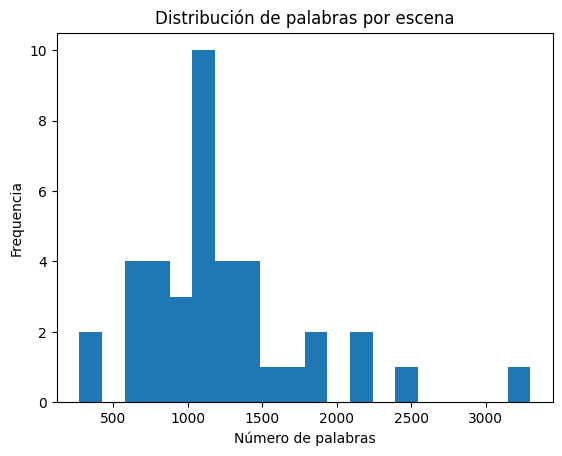

In [13]:
# Visualización: distribución de longitud de escenas
plt.hist(df['num_palabras'], bins=20)
plt.title("Distribución de palabras por escena")
plt.xlabel("Número de palabras")
plt.ylabel("Frequencia")
plt.show()

## Clasificación automática de emociones por escena

In [ ]:
from huggingface_hub import login
login('TOKEN')

In [15]:
from transformers import pipeline
from deep_translator import GoogleTranslator

emotion_classifier = pipeline('text-classification', model='j-hartmann/emotion-english-distilroberta-base', top_k=1, device=-1)

def detectar_emocion(texto):
    try:
        oraciones = re.split(r'[.!?]', texto)
        entrada = ' '.join(oraciones[:5]).strip()[:300]
        result = emotion_classifier(entrada)
        return result[0][0].get('label', 'desconocido')
    except Exception as e:
        print(f'Error:', e)
        return 'desconocido'
    
df['emocion'] = df['escena_texto'].apply(detectar_emocion)
df[['escena_texto', 'emocion']].head()

Device set to use cpu


,escena_texto,emocion
0,Escena 1\nScene Description:\nLocation & Actio...,fear
1,Escena 2\nScene Description:\nLocation & Actio...,fear
2,Escena 4\nScene Description (SLUG 4 - FLASHBAC...,neutral
3,Escena 6\nScene Description (SLUG 5 - MONTAGE ...,fear
4,Escena 7\nScene Description (SLUG 5 - MONTAGE ...,neutral


In [16]:
df['emocion'].value_counts()

emocion
neutral    17
fear       11
anger       7
sadness     3
disgust     1
Name: count, dtype: int64

## Clustering temático con Sentence Transformers

In [17]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

model = SentenceTransformer('distiluse-base-multilingual-cased-v1', device='cpu')
embeddings = model.encode(df['escena_texto'].tolist())
kmeans = KMeans(n_clusters=5, random_state=42)
df['tema_cluster'] = kmeans.fit_predict(embeddings)
df[['tema_cluster', 'escena_texto']].groupby('tema_cluster').head(1)

,tema_cluster,escena_texto
0,4,Escena 1\nScene Description:\nLocation & Actio...
2,0,Escena 4\nScene Description (SLUG 4 - FLASHBAC...
3,2,Escena 6\nScene Description (SLUG 5 - MONTAGE ...
9,1,Escena 13\nScene Description (SLUG 9 - MONTAGE...
25,3,Escena 37\nScene Description:\nSetting & Chara...


## Matriz de coaparición de personajes

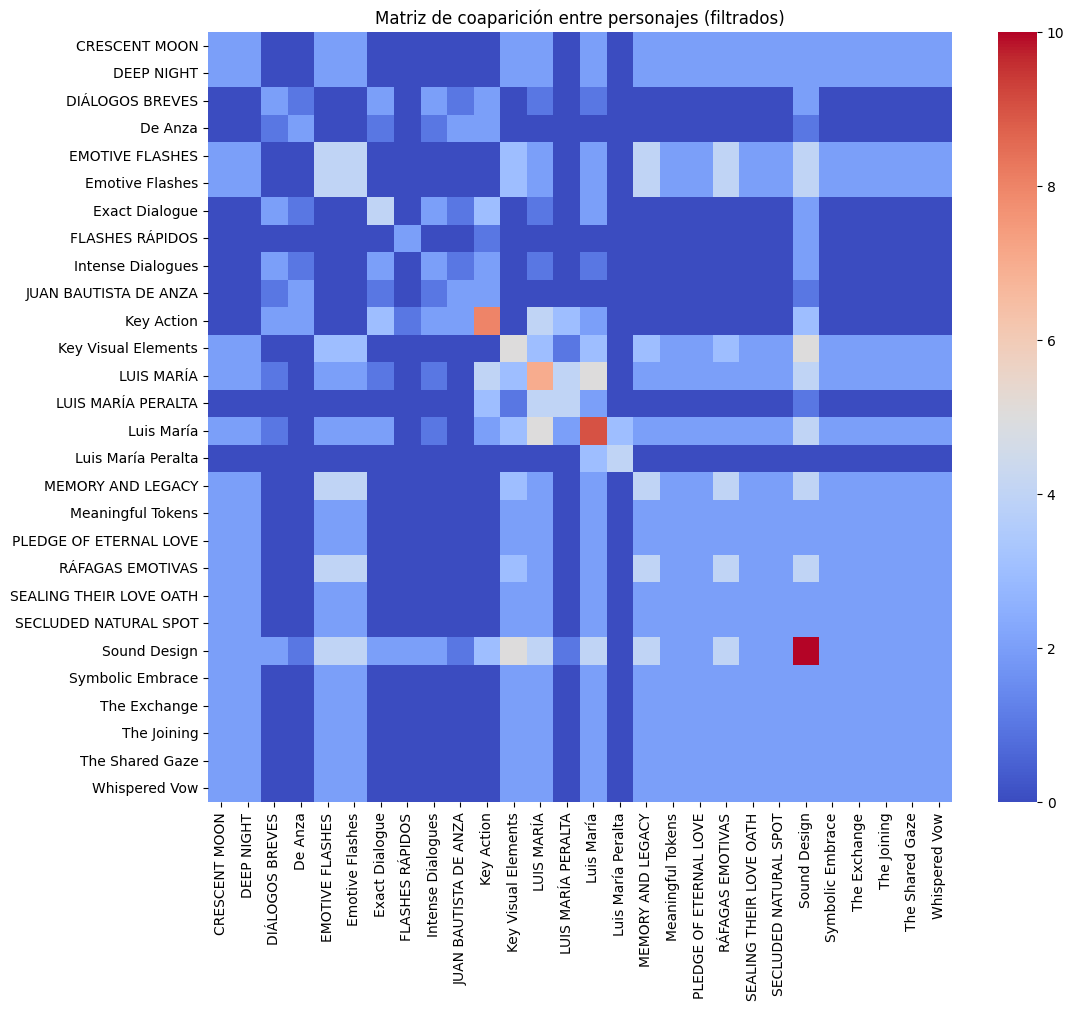

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
personajes_bin = mlb.fit_transform(df['personajes_filtrados'])
df_personajes = pd.DataFrame(personajes_bin, columns=mlb.classes_)
coaparicion = df_personajes.T.dot(df_personajes)
plt.figure(figsize=(12, 10))
sns.heatmap(coaparicion, cmap="coolwarm", annot=False)
plt.title("Matriz de coaparición entre personajes (filtrados)")
plt.show()

## Limpieza y tratamiento de valores nulos o atípicos

In [19]:
df['escena_text'] = df['escena_texto'].str.strip()
print('Valores nulos por columna: ')
print(df.isnull().sum())
df.fillna("desconocido", inplace=True)

Valores nulos por columna: 
escena_texto             0
escena_num               0
num_palabras             0
personajes_detectados    0
personajes_filtrados     0
emocion                  0
tema_cluster             0
escena_text              0
dtype: int64


## Conclusiones del Análisis Exploratorio

In [20]:
print('Total de escenas:')
print(len(df))

Total de escenas:
39


In [21]:
print('\nEscenas más extensas:')
print(df.sort_values(by='num_palabras', ascending=False).head(5)[['num_palabras', 'escena_texto']])


Escenas más extensas:
    num_palabras                                       escena_texto
37          3298  Escena 50\nScene Description (Visuals - Montag...
27          2537  Escena 39\nScene Description (Visuals - Montag...
19          2227  Escena 28\nOverall Visual Concept for this Mon...
20          2225  Escena 30\nScene Description:\nSetting & Chara...
17          1932  Escena 25\nScene Description (Visuals):\nSetti...


In [22]:
print('\nDistribución de emociones:')
print(df['emocion'].value_counts())


Distribución de emociones:
emocion
neutral    17
fear       11
anger       7
sadness     3
disgust     1
Name: count, dtype: int64


In [23]:
print('\nTop personajes:')
print(df['personajes_filtrados'].explode().value_counts().head(10))


Top personajes:
personajes_filtrados
Sound Design           10
Luis María              9
Key Action              8
LUIS MARÍA              7
Key Visual Elements     5
Exact Dialogue          4
Luis María Peralta      4
LUIS MARÍA PERALTA      4
MEMORY AND LEGACY       4
EMOTIVE FLASHES         4
Name: count, dtype: int64


In [24]:
# Calcular datos necesarios para el dashboard

# Escenas por personaje (Top 10)
personajes_escenas = df['personajes_filtrados'].explode().value_counts().head(10)

# Emociones detectadas
emociones = df['emocion'].value_counts()

# Clusters temáticos (si existe esa columna)
if 'tema_cluster' in df.columns:
    temas = df['tema_cluster'].value_counts().sort_index()
else:
    temas = pd.Series()


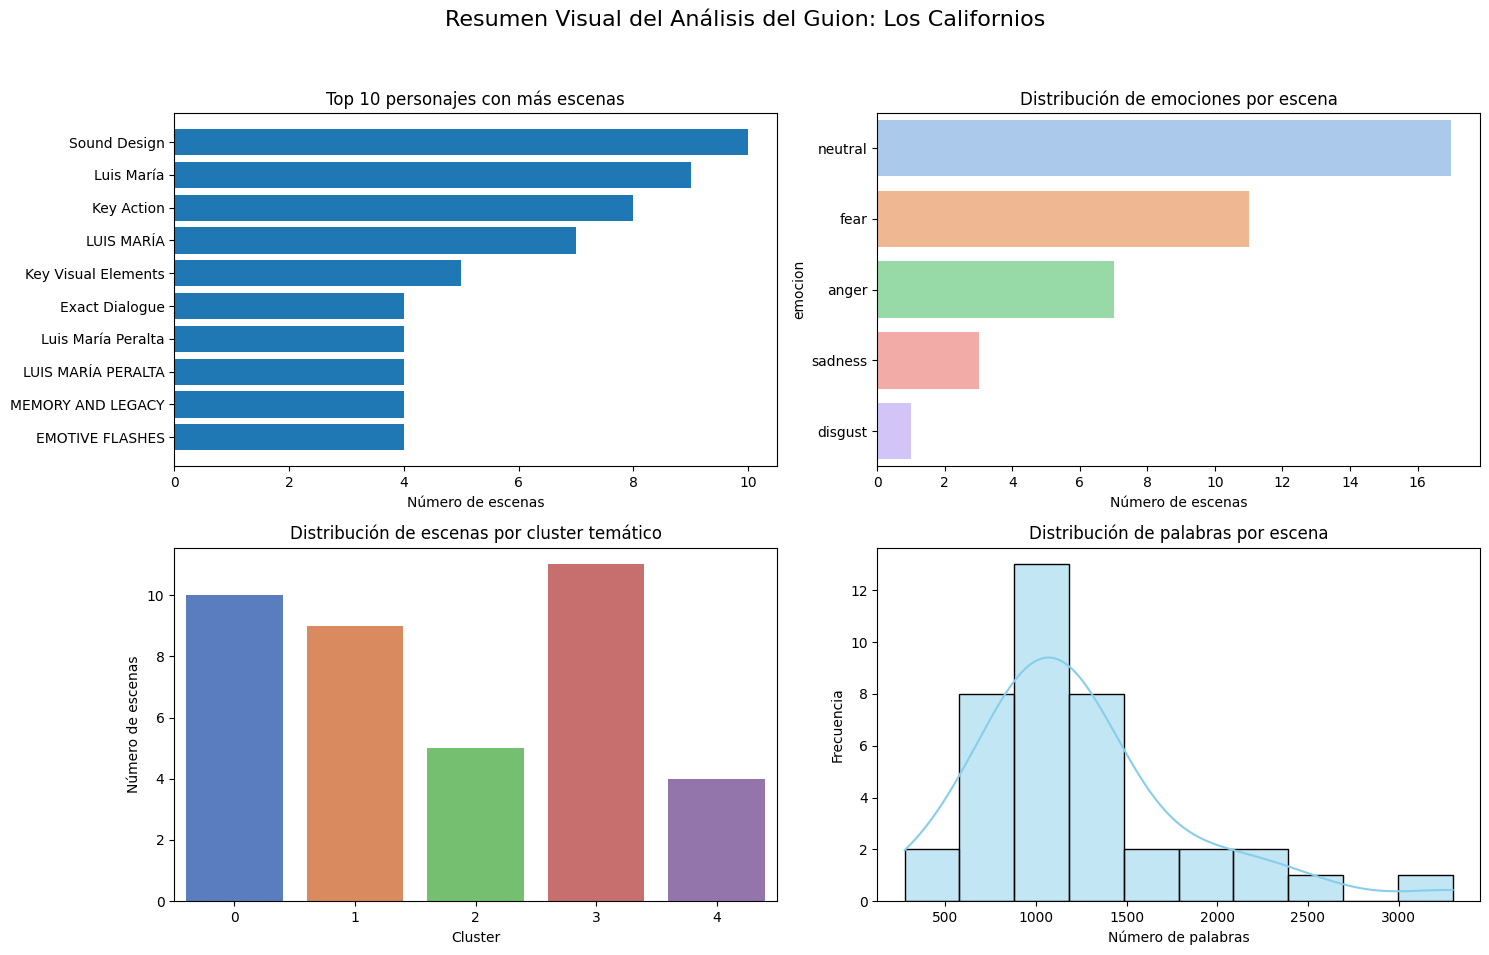

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Resumen Visual del Análisis del Guion: Los Californios", fontsize=16)

# Gráfico 1: Top personajes
axs[0, 0].barh(personajes_escenas.index[::-1], personajes_escenas.values[::-1])
axs[0, 0].set_title("Top 10 personajes con más escenas")
axs[0, 0].set_xlabel("Número de escenas")

# Gráfico 2: Emociones
sns.barplot(x=emociones.values, y=emociones.index, ax=axs[0, 1], palette="pastel")
axs[0, 1].set_title("Distribución de emociones por escena")
axs[0, 1].set_xlabel("Número de escenas")

# Gráfico 3: Clusters temáticos
sns.barplot(x=temas.index, y=temas.values, ax=axs[1, 0], palette="muted")
axs[1, 0].set_title("Distribución de escenas por cluster temático")
axs[1, 0].set_xlabel("Cluster")
axs[1, 0].set_ylabel("Número de escenas")

# Gráfico 4: Longitud de escenas
sns.histplot(df['num_palabras'], bins=10, kde=True, ax=axs[1, 1], color='skyblue')
axs[1, 1].set_title("Distribución de palabras por escena")
axs[1, 1].set_xlabel("Número de palabras")
axs[1, 1].set_ylabel("Frecuencia")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Importación de paquetes necesarios

In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

## Generación y codificación de nuevas características

In [27]:
df = pd.concat([df, pd.get_dummies(df['emocion'], prefix='em')], axis=1)
df['num_personajes'] = df['personajes_filtrados'].apply(len)
df['escena_coral'] = (df['num_personajes'] > 1).astype(int)
df.head()

,escena_texto,escena_num,num_palabras,personajes_detectados,personajes_filtrados,emocion,tema_cluster,escena_text,em_anger,em_disgust,em_fear,em_neutral,em_sadness,num_personajes,escena_coral
0,Escena 1\nScene Description:\nLocation & Actio...,1,275,[],[],fear,4,Escena 1\nScene Description:\nLocation & Actio...,False,False,True,False,False,0,0
1,Escena 2\nScene Description:\nLocation & Actio...,2,313,[],[],fear,4,Escena 2\nScene Description:\nLocation & Actio...,False,False,True,False,False,0,0
2,Escena 4\nScene Description (SLUG 4 - FLASHBAC...,4,1151,"[TUBAC MISSION, Tubac Mission, Key Action, BAS...","[Key Action, JUAN BAUTISTA DE ANZA, De Anza]",neutral,0,Escena 4\nScene Description (SLUG 4 - FLASHBAC...,False,False,False,True,False,3,1
3,Escena 6\nScene Description (SLUG 5 - MONTAGE ...,6,667,[],[],fear,2,Escena 6\nScene Description (SLUG 5 - MONTAGE ...,False,False,True,False,False,0,0
4,Escena 7\nScene Description (SLUG 5 - MONTAGE ...,7,679,[],[],neutral,2,Escena 7\nScene Description (SLUG 5 - MONTAGE ...,False,False,False,True,False,0,0


## Normalización de variables numéricas

In [28]:
scaler = MinMaxScaler()
df[['norm_longitud', 'norm_personajes']] = scaler.fit_transform(df[['num_palabras', 'num_personajes']])
df.head()

,escena_texto,escena_num,num_palabras,personajes_detectados,personajes_filtrados,emocion,tema_cluster,escena_text,em_anger,em_disgust,em_fear,em_neutral,em_sadness,num_personajes,escena_coral,norm_longitud,norm_personajes
0,Escena 1\nScene Description:\nLocation & Actio...,1,275,[],[],fear,4,Escena 1\nScene Description:\nLocation & Actio...,False,False,True,False,False,0,0,0.000000,0.000000
1,Escena 2\nScene Description:\nLocation & Actio...,2,313,[],[],fear,4,Escena 2\nScene Description:\nLocation & Actio...,False,False,True,False,False,0,0,0.012570,0.000000
2,Escena 4\nScene Description (SLUG 4 - FLASHBAC...,4,1151,"[TUBAC MISSION, Tubac Mission, Key Action, BAS...","[Key Action, JUAN BAUTISTA DE ANZA, De Anza]",neutral,0,Escena 4\nScene Description (SLUG 4 - FLASHBAC...,False,False,False,True,False,3,1,0.289778,0.157895
3,Escena 6\nScene Description (SLUG 5 - MONTAGE ...,6,667,[],[],fear,2,Escena 6\nScene Description (SLUG 5 - MONTAGE ...,False,False,True,False,False,0,0,0.129673,0.000000
4,Escena 7\nScene Description (SLUG 5 - MONTAGE ...,7,679,[],[],neutral,2,Escena 7\nScene Description (SLUG 5 - MONTAGE ...,False,False,False,True,False,0,0,0.133642,0.000000


## Selección y reducción de características

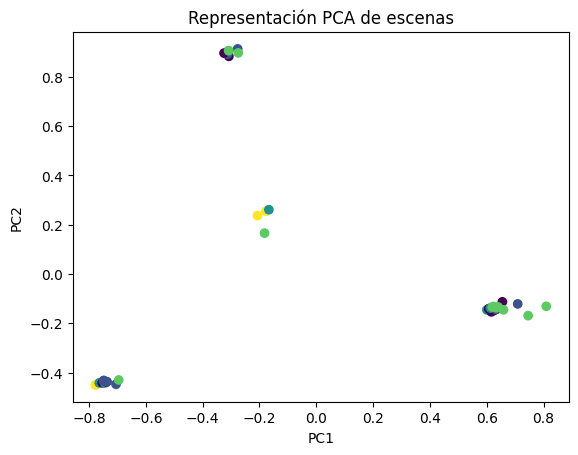

In [29]:
columnas_emocion = list(df.columns[df.columns.str.startswith('em_')])
X = df[['norm_longitud', 'norm_personajes'] + columnas_emocion]

selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['tema_cluster'], cmap='viridis')
plt.title('Representación PCA de escenas')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Similitud entre escenas y personajes con embeddings

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Se extraen las escenas y se generan nombres de escenas
escenas = df['escena_texto'].tolist()
nombres_escenas = [f'Escena {i+1}' for i in range(len(escenas))]

# Se carga el modelo y se generan los embeddings
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
embeddings = model.encode(escenas)

# Se calcula matriz de similitud
sim_matrix = cosine_similarity(embeddings)

# Se genera un dataframe temporal para desplegar los resultados de forma legible.
df_sim = pd.DataFrame(sim_matrix, index=nombres_escenas, columns=nombres_escenas)

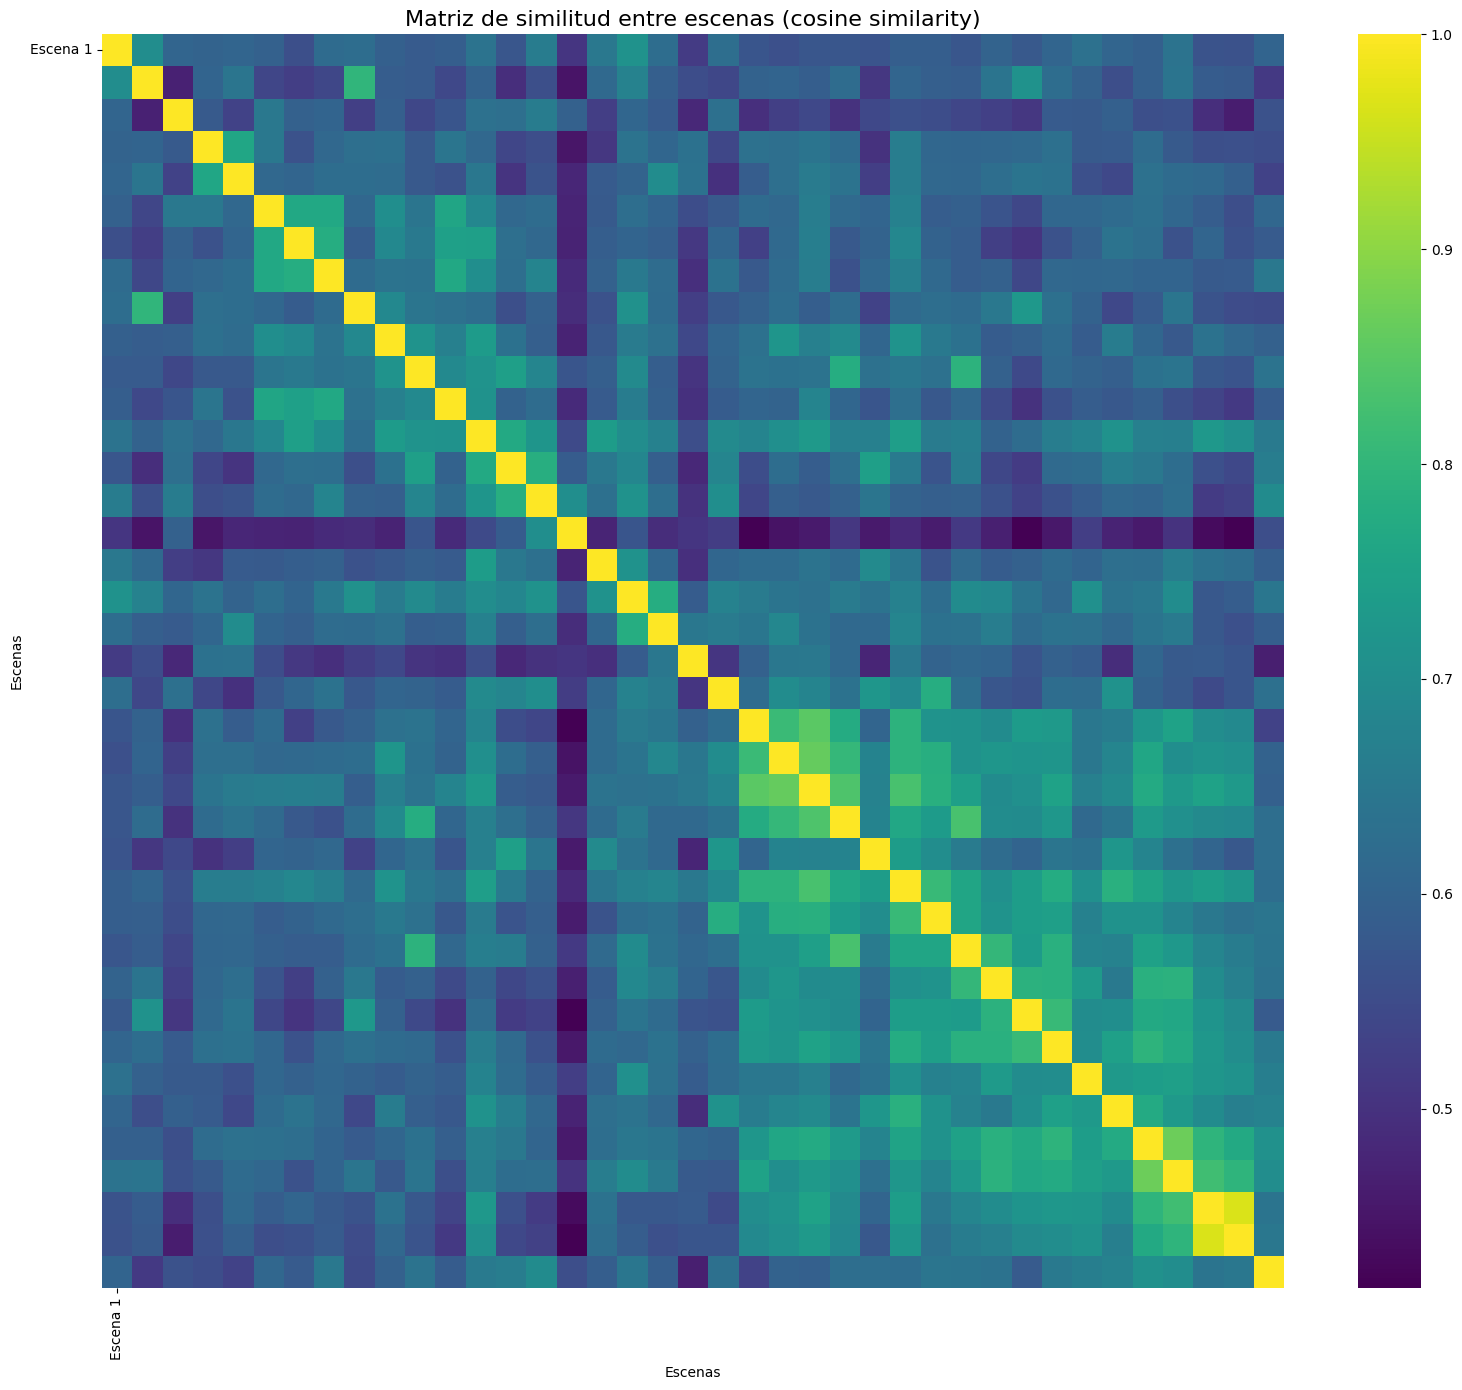

In [31]:
# Mostrar heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(df_sim, cmap='viridis', xticklabels=50, yticklabels=50)
plt.title('Matriz de similitud entre escenas (cosine similarity)', fontsize=16)
plt.xlabel('Escenas')
plt.ylabel('Escenas')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [32]:
df_sim.head()

,Escena 1,Escena 2,Escena 3,Escena 4,Escena 5,Escena 6,Escena 7,Escena 8,Escena 9,Escena 10,...,Escena 30,Escena 31,Escena 32,Escena 33,Escena 34,Escena 35,Escena 36,Escena 37,Escena 38,Escena 39
Escena 1,1.000000,0.699790,0.603753,0.598846,0.604198,0.594429,0.556312,0.618112,0.621753,0.593783,...,0.599806,0.577944,0.603968,0.631698,0.603456,0.592296,0.638530,0.565696,0.563329,0.602067
Escena 2,0.699790,1.000000,0.470589,0.603284,0.642669,0.537833,0.522325,0.541352,0.798384,0.585179,...,0.640635,0.712225,0.621611,0.595621,0.555394,0.593684,0.641950,0.582902,0.579844,0.513946
Escena 3,0.603753,0.470589,1.000000,0.579008,0.530695,0.651092,0.595274,0.601795,0.525823,0.590421,...,0.526625,0.507945,0.581842,0.580381,0.594164,0.557106,0.561993,0.493308,0.462488,0.562766
Escena 4,0.598846,0.603284,0.579008,1.000000,0.761502,0.650688,0.564169,0.611331,0.626280,0.630252,...,0.609795,0.613336,0.629011,0.579928,0.581463,0.619946,0.579711,0.556660,0.558959,0.551817
Escena 5,0.604198,0.642669,0.530695,0.761502,1.000000,0.610497,0.605254,0.622780,0.622026,0.620934,...,0.625523,0.639880,0.637560,0.558967,0.542179,0.631206,0.617589,0.613722,0.592364,0.530714


In [33]:
import numpy as np
# Convertir la matriz en formato largo (pares de escena)
sim_pairs = df_sim.where(~np.eye(df_sim.shape[0], dtype=bool))  # Elimina la diagonal (1.0 de autocomparación)
sim_pairs = sim_pairs.stack().reset_index()
sim_pairs.columns = ['Escena A', 'Escena B', 'Similaridad']

# Ordenar de mayor a menor
sim_pairs = sim_pairs.sort_values(by='Similaridad', ascending=False)

# Opcional: eliminar duplicados (Ej: A-B y B-A)
sim_pairs['Escenas'] = sim_pairs[['Escena A', 'Escena B']].apply(lambda x: tuple(sorted(x)), axis=1)
sim_pairs = sim_pairs.drop_duplicates(subset='Escenas').drop(columns='Escenas')

# Mostrar top 10 pares más similares
print('10 escenas con mayor similitud:')
sim_pairs.head(10)

10 escenas con mayor similitud:


,Escena A,Escena B,Similaridad
1404,Escena 37,Escena 38,0.967831
1326,Escena 35,Escena 36,0.868559
896,Escena 24,Escena 23,0.863020
820,Escena 22,Escena 24,0.850480
897,Escena 24,Escena 25,0.836550
899,Escena 24,Escena 27,0.830214
1088,Escena 29,Escena 25,0.829711
1365,Escena 36,Escena 37,0.821908
819,Escena 22,Escena 23,0.811311
1052,Escena 28,Escena 27,0.809859


## Baseline usando el dataframe

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, chi2

In [35]:
X_texto = df['escena_texto']
y = df['emocion']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_texto)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Entrenamiento del modelo baseline y evaluación

In [36]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.6666666666666666
F1 Score: 0.5787037037037037

Reporte de clasificación:

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         1
        fear       1.00      0.33      0.50         3
     neutral       0.64      1.00      0.78         7
     sadness       0.00      0.00      0.00         1

    accuracy                           0.67        12
   macro avg       0.41      0.33      0.32        12
weighted avg       0.62      0.67      0.58        12



## Palabras más relevantes según chi-cuadrado

In [37]:
selector = SelectKBest(score_func=chi2, k=10)
selector.fit(X, y)
selected_words = np.array(vectorizer.get_feature_names_out())[selector.get_support()]
print("Palabras más importantes según chi2:", selected_words)

Palabras más importantes según chi2: ['ancient' 'cream' 'desert' 'document' 'ellipsis' 'font' 'ink'
 'legibility' 'map' 'text']


## Visualización PCA de escenas por emoción

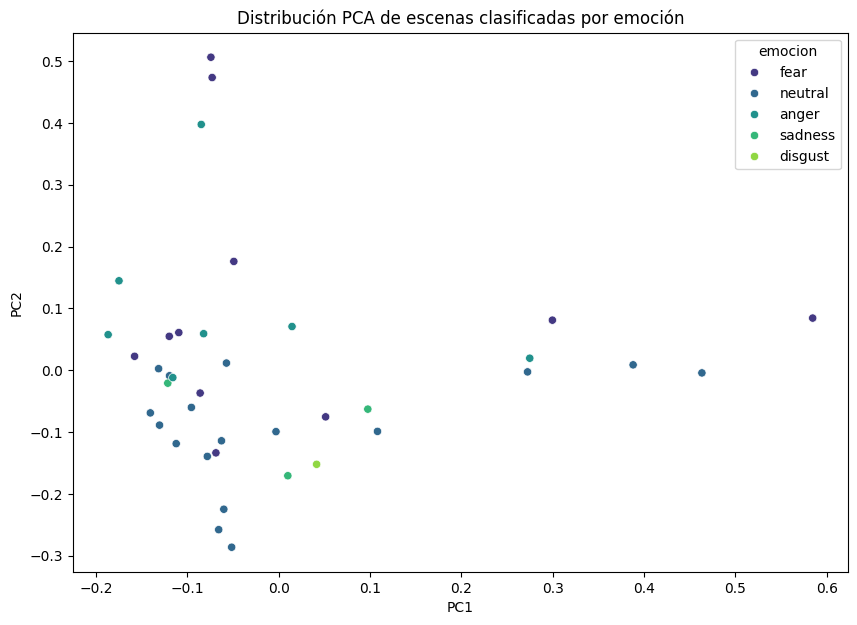

In [38]:
X_dense = X.toarray()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['emocion'] = y.values

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='emocion', palette='viridis')
plt.title("Distribución PCA de escenas clasificadas por emoción")
plt.show()

## Validación cruzada del modelo baseline

In [39]:
scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
print("F1 ponderado promedio (CV 5-fold):", np.mean(scores))

F1 ponderado promedio (CV 5-fold): 0.2665800865800866


## Preparación de datos

In [40]:
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [41]:
# Verifica cuántas muestras hay por clase
conteo_clases = df['emocion'].value_counts()
clases_validas = conteo_clases[conteo_clases >= 2].index

# Filtra solo escenas con emociones que tienen al menos 2 ocurrencias
df_filtrado = df[df['emocion'].isin(clases_validas)].copy()

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_filtrado['escena_texto'])
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_filtrado['emocion'])

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [42]:
print("Clases en y_train:", np.unique(y_train))
print("Clases en y_test:", np.unique(y_test))
print("Clases totales:", label_encoder.classes_)


Clases en y_train: [0 1 2 3]
Clases en y_test: [0 1 2 3]
Clases totales: ['anger' 'fear' 'neutral' 'sadness']


## Entrenamiento de modelos individuales

In [43]:
from sklearn.base import clone

modelos = {
    'LogisticRegression': lambda: LogisticRegression(max_iter=1000),
    'MultinomialNB': lambda: MultinomialNB(),
    'RandomForest': lambda: RandomForestClassifier(),
    'KNeighbors': lambda: KNeighborsClassifier(),
    'SVC': lambda: SVC(),
    'XGBoost': lambda: XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

resultados = []
for nombre, modelo_fn in modelos.items():
    modelo = modelo_fn()  # Se crea una nueva instancia fresca
    start = time.time()
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    duracion = time.time() - start
    resultados.append({
        'modelo': nombre,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'tiempo_seg': duracion
    })

## Comparativa de resultados

,modelo,accuracy,f1_macro,f1_weighted,tiempo_seg
3,KNeighbors,0.666667,0.330882,0.605392,0.006001
0,LogisticRegression,0.666667,0.319444,0.578704,0.734947
2,RandomForest,0.583333,0.276471,0.511765,0.509996
5,XGBoost,0.333333,0.205556,0.405556,0.466003
1,MultinomialNB,0.583333,0.184211,0.429825,0.006005
4,SVC,0.583333,0.184211,0.429825,0.017997


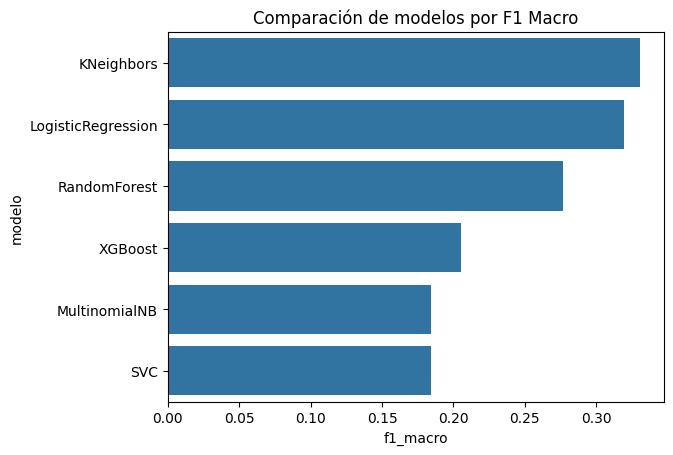

In [44]:
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by='f1_macro', ascending=False)
display(df_resultados)

sns.barplot(x='f1_macro', y='modelo', data=df_resultados)
plt.title('Comparación de modelos por F1 Macro')
plt.show()

## Ajuste fino de los dos mejores modelos

In [45]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1]
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    param_grid=param_xgb,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)
print("Mejor score (XGBoost):", grid_xgb.best_score_)
print("Mejores parámetros:", grid_xgb.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Mejor score (XGBoost): 0.49484126984126986
Mejores parámetros: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_knn,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)
print("Mejor score (KNN):", grid_knn.best_score_)
print("Mejores parámetros:", grid_knn.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejor score (KNN): 0.45383597883597887
Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}


## Ensambles

### Entrenar al menos 4 modelos de ensamble:

#### 2 homogéneos:
- Random Forest
- XGBoost

#### 2 heterogéneos:
- VotingClassifier
- StackingClassifier


In [47]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Modelos base ya ajustados previamente
estimadores_stack = [
    ('knn', KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean')),
    ('xgb', XGBClassifier(n_estimators=50, max_depth=10, learning_rate=0.01, subsample=1, use_label_encoder=False, eval_metric='mlogloss')),
    ('svc', SVC(probability=True))
]

# Modelos de ensamble
modelos_ensamble = {
    'RandomForest': RandomForestClassifier(n_estimators=200),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss'),
    'Voting': VotingClassifier(estimators=estimadores_stack, voting='soft'),
    'Stacking': StackingClassifier(estimators=estimadores_stack, final_estimator=LogisticRegression())
}

# Evaluación de modelos
resultados_ensamble = []
for nombre, modelo in modelos_ensamble.items():
    start = time.time()
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    duracion = time.time() - start
    resultados_ensamble.append({
        'modelo': nombre,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'tiempo_seg': duracion
    })

# Resultados ordenados por F1 macro
df_ensamble = pd.DataFrame(resultados_ensamble).sort_values(by='f1_macro', ascending=False)
display(df_ensamble)


,modelo,accuracy,f1_macro,f1_weighted,tiempo_seg
0,RandomForest,0.583333,0.276471,0.511765,1.069663
3,Stacking,0.583333,0.205882,0.480392,3.785484
1,XGBoost,0.333333,0.205556,0.405556,0.754770
2,Voting,0.583333,0.194444,0.453704,0.737981


### Modelo Final Seleccionado

In [48]:
modelo_final = modelos_ensamble['XGBoost']
y_pred_final = modelo_final.predict(X_test)

### Matriz de Confusión

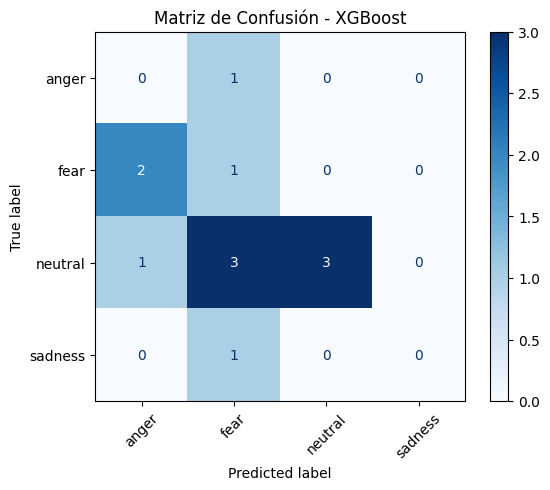

In [49]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de Confusión - XGBoost")
plt.show()

### Curvas ROC multiclase

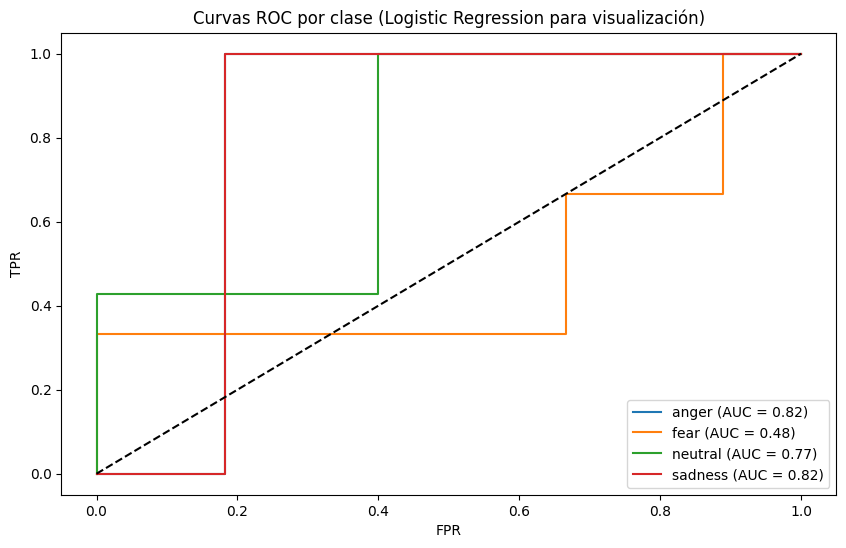

In [50]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

# Reentrenamos para fines visuales solamente
logreg_ovr = OneVsRestClassifier(LogisticRegression(max_iter=1000))
logreg_ovr.fit(X_train, y_train)

y_score = logreg_ovr.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=label_encoder.transform(label_encoder.classes_))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Curvas ROC por clase (Logistic Regression para visualización)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

### Importancia de Características

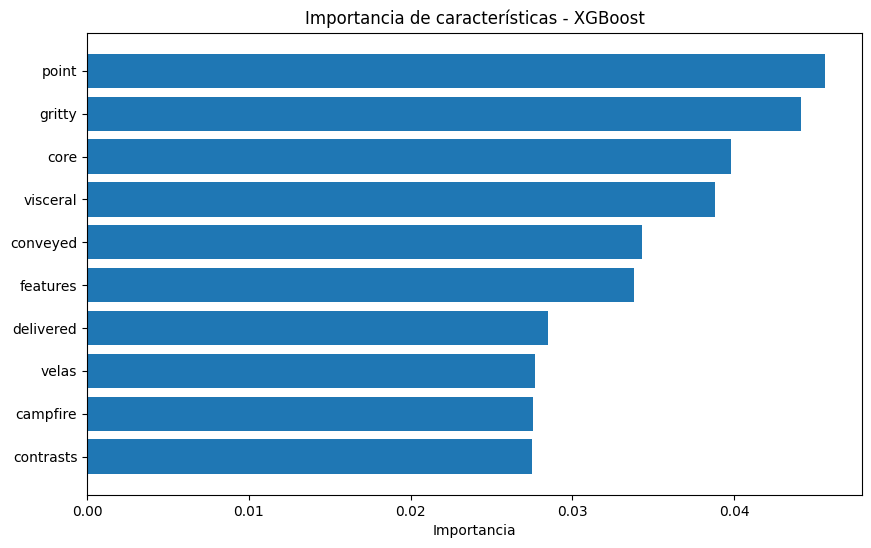

In [51]:
importances = modelo_final.feature_importances_
feature_names = vectorizer.get_feature_names_out()
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("Importancia de características - XGBoost")
plt.xlabel("Importancia")
plt.show()

### Modelo alternativo de HuggingFace

In [52]:
from transformers import pipeline

# Usar modelo robusto desde Hugging Face
clasificador = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment", top_k=1)

def obtener_emocion(texto):
    resultado = clasificador(texto[:512])  # evitar textos demasiado largos
    return resultado[0][0]['label']

df['emocion_alt'] = df['escena_texto'].apply(obtener_emocion)


Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [53]:
etiquetas = {'LABEL_0': 'negative', 'LABEL_1': 'neutral', 'LABEL_2': 'positive'}
df['emocion_alt'] = df['emocion_alt'].map(etiquetas)

In [54]:
df['emocion_alt'].value_counts()

emocion_alt
neutral     32
positive     6
negative     1
Name: count, dtype: int64

### Generación de *prompt* de escenas con emoción

In [55]:
df.head()

,escena_texto,escena_num,num_palabras,personajes_detectados,personajes_filtrados,emocion,tema_cluster,escena_text,em_anger,em_disgust,em_fear,em_neutral,em_sadness,num_personajes,escena_coral,norm_longitud,norm_personajes,emocion_alt
0,Escena 1\nScene Description:\nLocation & Actio...,1,275,[],[],fear,4,Escena 1\nScene Description:\nLocation & Actio...,False,False,True,False,False,0,0,0.000000,0.000000,neutral
1,Escena 2\nScene Description:\nLocation & Actio...,2,313,[],[],fear,4,Escena 2\nScene Description:\nLocation & Actio...,False,False,True,False,False,0,0,0.012570,0.000000,neutral
2,Escena 4\nScene Description (SLUG 4 - FLASHBAC...,4,1151,"[TUBAC MISSION, Tubac Mission, Key Action, BAS...","[Key Action, JUAN BAUTISTA DE ANZA, De Anza]",neutral,0,Escena 4\nScene Description (SLUG 4 - FLASHBAC...,False,False,False,True,False,3,1,0.289778,0.157895,neutral
3,Escena 6\nScene Description (SLUG 5 - MONTAGE ...,6,667,[],[],fear,2,Escena 6\nScene Description (SLUG 5 - MONTAGE ...,False,False,True,False,False,0,0,0.129673,0.000000,neutral
4,Escena 7\nScene Description (SLUG 5 - MONTAGE ...,7,679,[],[],neutral,2,Escena 7\nScene Description (SLUG 5 - MONTAGE ...,False,False,False,True,False,0,0,0.133642,0.000000,positive


In [56]:
ruta_escenas = Path('../data/LosCaliforniosScenesEmotions.txt')

with open(ruta_escenas, "w", encoding="utf-8") as f:
    for _, row in df.iterrows():
        escena = row['escena_texto'].strip()
        emocion = row['emocion']
        f.write(f"{escena}\nThis scene should generate, in the viewer, the emotion: {emocion}\n\n")
